# Experiment 1

The purpose of this first experiment is just to give us a better insight of the dataset, the behavior of parameters and also to consider and evaluate the computational resources.

For this first experimento we are going to evaluate using some EfficienNet model, fine-tuning using multiple dense layers and to try a decent fit for the 256x256 dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import sklearn
import matplotlib

C:\Users\pedro\OneDrive\Escritorio\Proyecto_IA_SS\venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
# Data preparation

def read_and_decode(filename):
  # 1-> Read the file
  img = tf.io.read_file(filename)
  # 2-> Convert compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # 3-> Convert 3D uint8 to floats in the range [0,1]
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

def decode_csv(csv_row):
  record_defaults = ["filepaths", "labels"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename)
  # label = tf.math.equal(CLASS_NAMES, label_string)
  return img, label_string

dataset = (tf.data.TextLineDataset(
    "new_train.csv").
    map(decode_csv))

In [3]:
for img, label in dataset.take(5):
  avg = tf.math.reduce_mean(img, axis=[0, 1]) # average pixel in the image
  print(label, avg)

tf.Tensor(b'0', shape=(), dtype=string) tf.Tensor([0.06334462 0.06334462 0.06334462], shape=(3,), dtype=float32)
tf.Tensor(b'0', shape=(), dtype=string) tf.Tensor([0.10289186 0.10289186 0.10289186], shape=(3,), dtype=float32)
tf.Tensor(b'0', shape=(), dtype=string) tf.Tensor([0.09715645 0.09715645 0.09715645], shape=(3,), dtype=float32)
tf.Tensor(b'0', shape=(), dtype=string) tf.Tensor([0.05162391 0.05162391 0.05162391], shape=(3,), dtype=float32)
tf.Tensor(b'0', shape=(), dtype=string) tf.Tensor([0.09223529 0.09223529 0.09223529], shape=(3,), dtype=float32)


In [4]:
def plot_images(filename):
  matplotlib.rcParams.update({'font.size': 14})
  f, ax = plt.subplots(3, 5, figsize=(35,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    ax[idx//5, idx%5].axis('off')

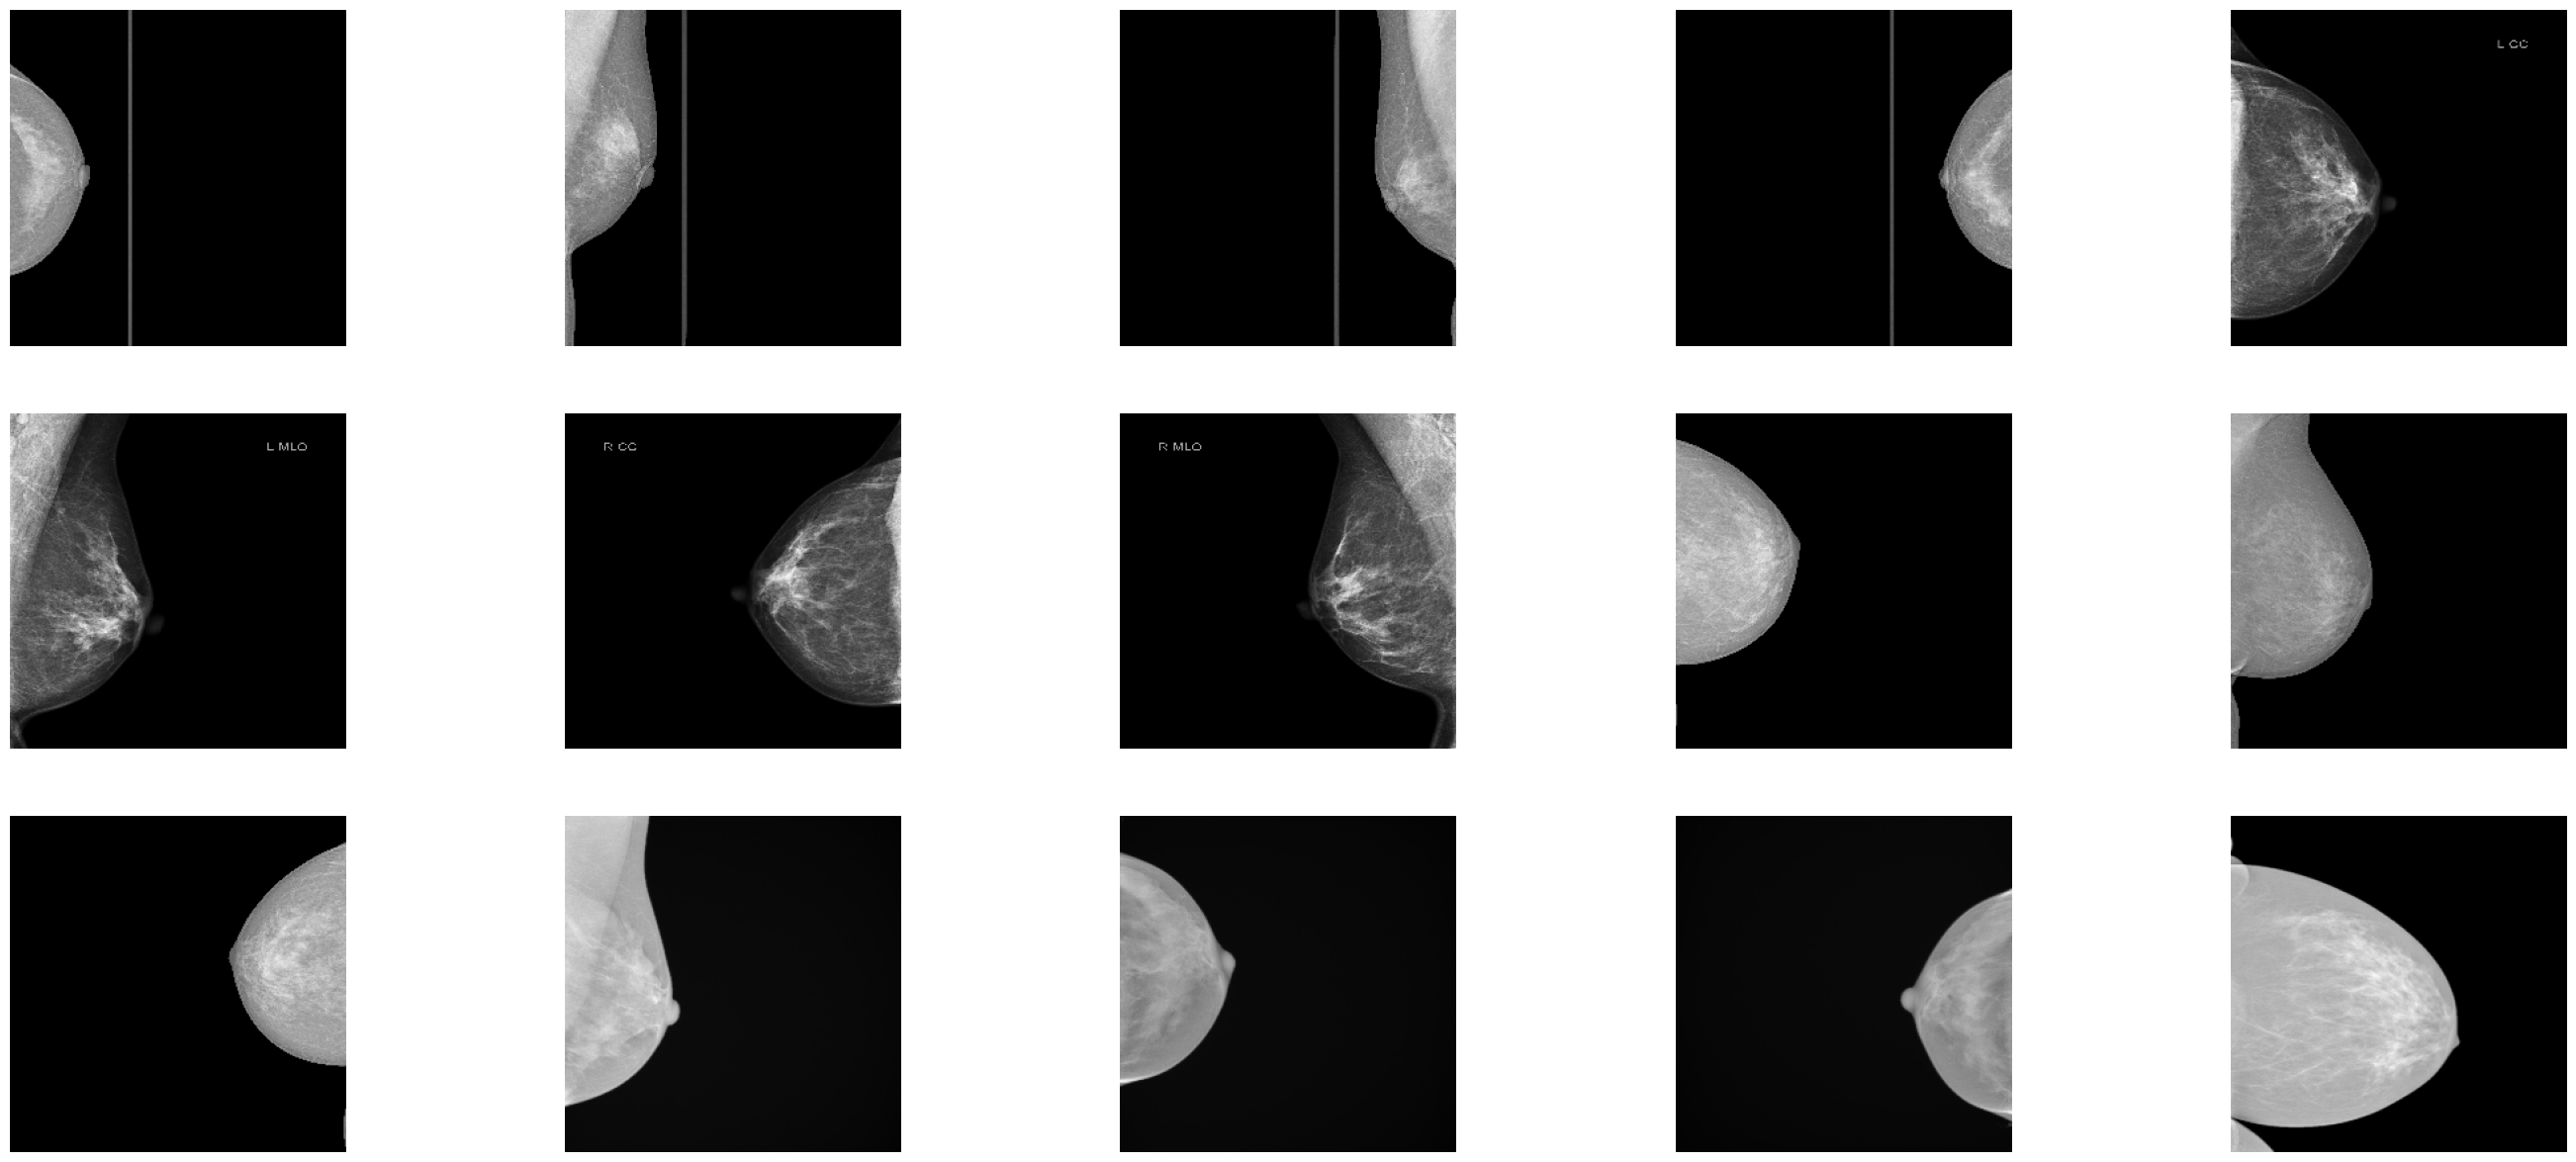

In [7]:
plot_images("new_train.csv")

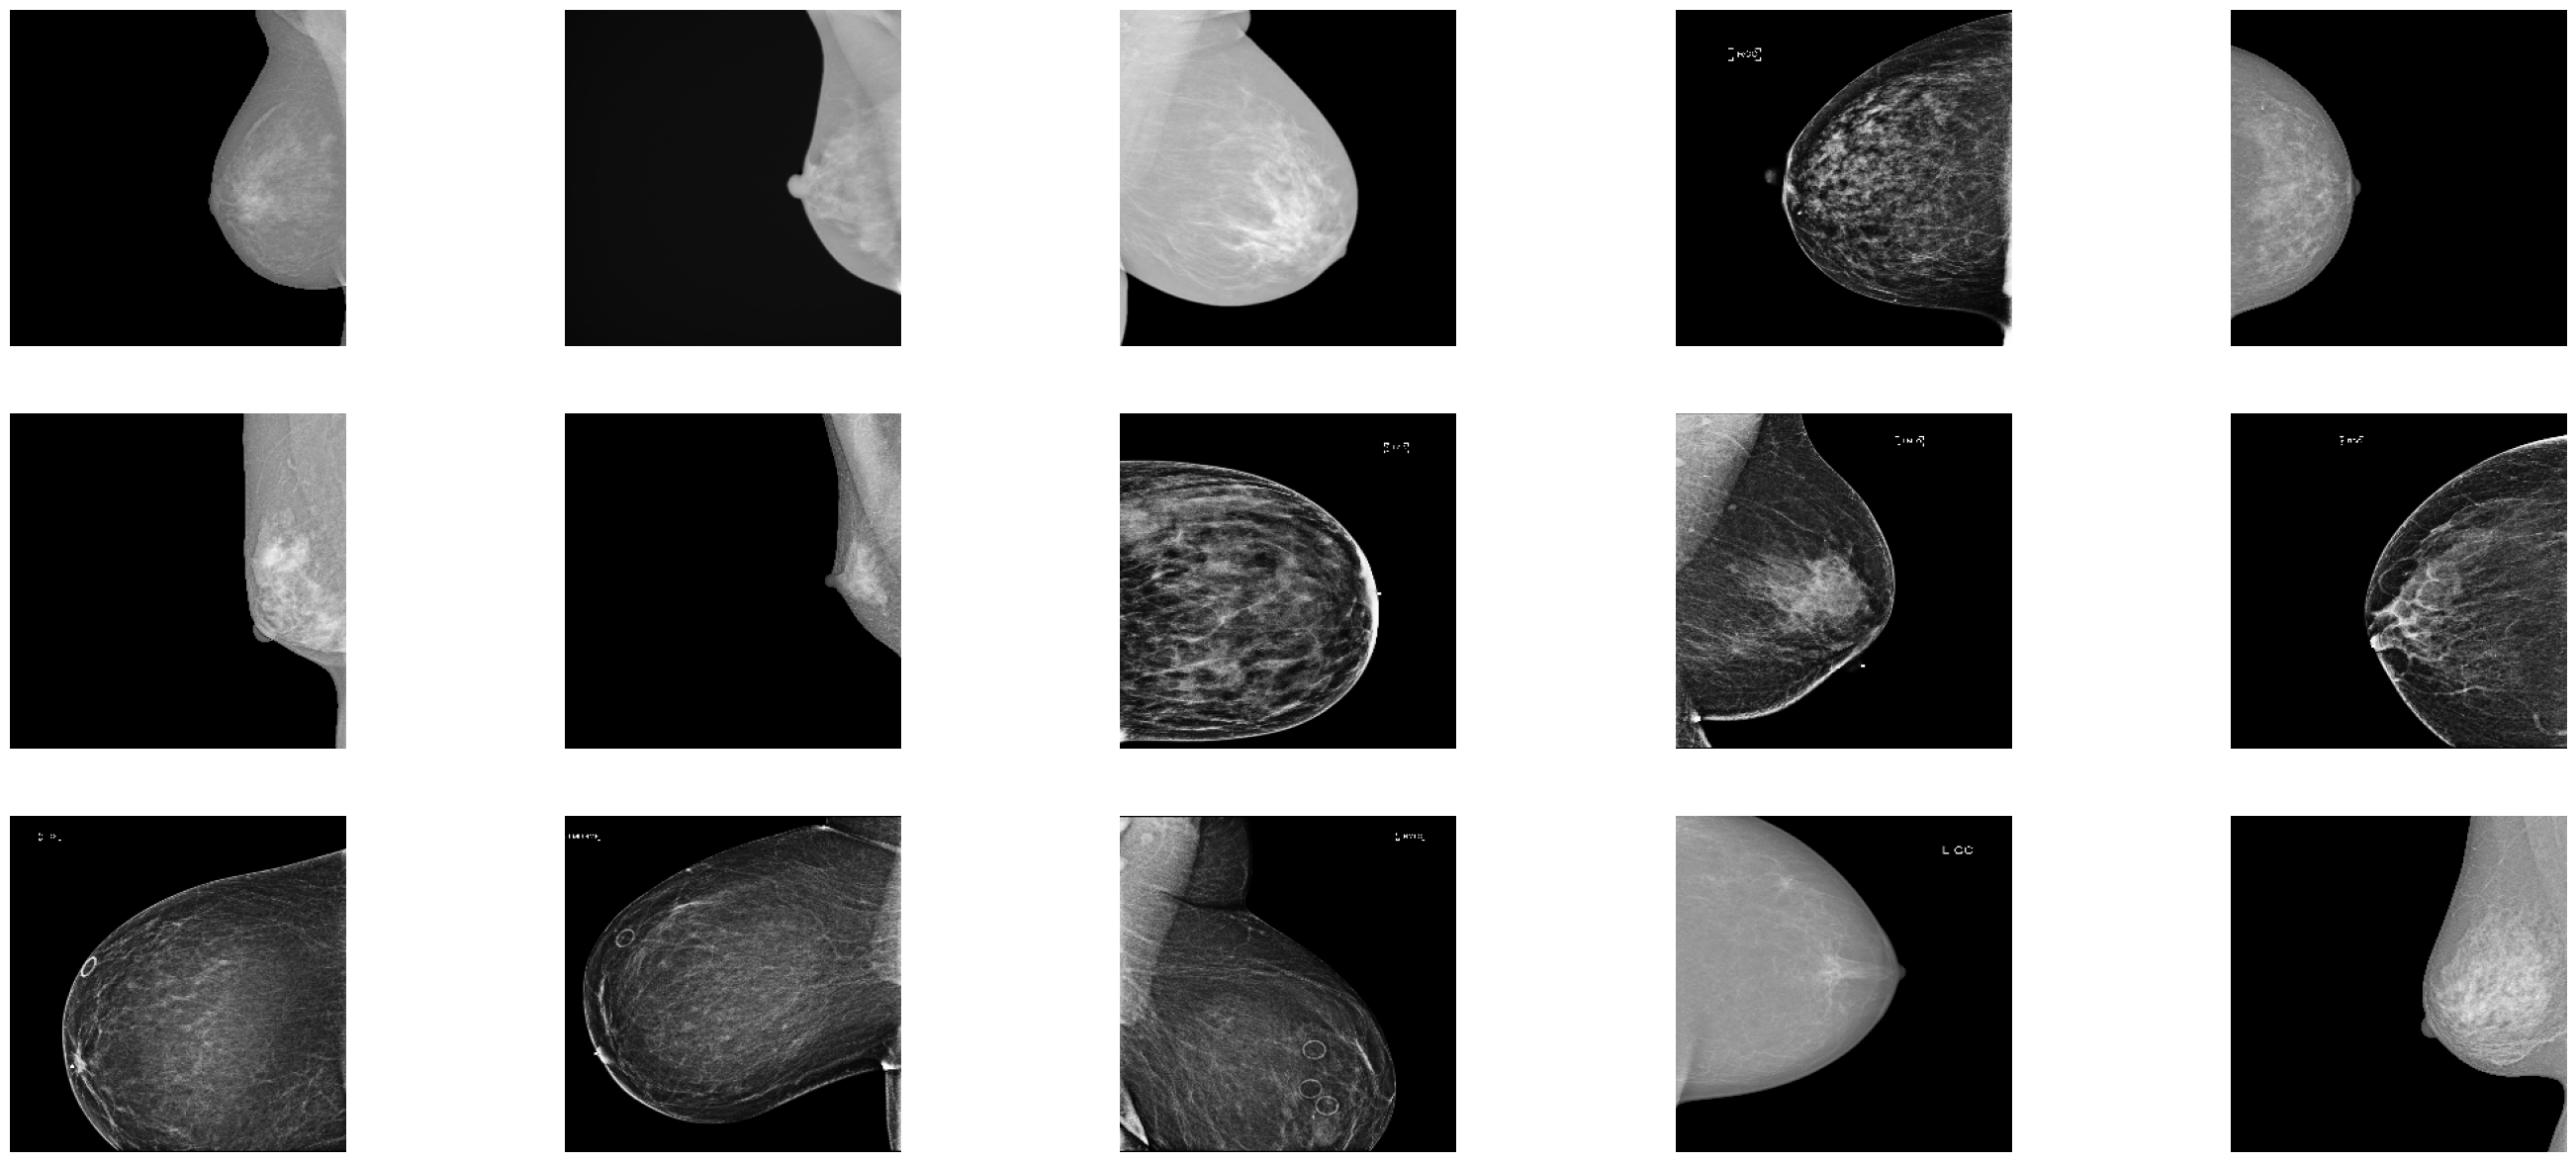

In [6]:
plot_images("new_test.csv")

In [68]:
def _decode_csv(csv_row):
    record_defaults = ["path", "class"]
    try:
        filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
        img = read_and_decode(filename)
        label = tf.argmax(tf.math.equal(["0","1"], label_string))
    except:
        print('File corrupted')
    return img, label


train_dataset = (tf.data.TextLineDataset('new_train.csv').map(_decode_csv)).batch(32)
test_dataset = (tf.data.TextLineDataset('new_test.csv').map(_decode_csv)).batch(32)

In [70]:
train_dataset, test_dataset

(<_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [40]:
labels = pd.read_csv('new_train.csv')
labels.loc[:, '0']

0        0
1        0
2        0
3        0
4        0
        ..
43827    0
43828    0
43829    0
43830    0
43831    0
Name: 0, Length: 43832, dtype: int64

In [42]:
# Calculating class weights to deal data imbalance

from sklearn.utils import compute_class_weight

train_labels = labels.loc[:, '0']

class_weights = compute_class_weight(class_weight = "balanced",
                                     classes= np.unique(train_labels),
                                     y= train_labels)

class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

{0: 0.5107791269489826, 1: 23.692972972972974}

In [10]:
# plotting utilities
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])

In [11]:
# custom metric

class pFBeta(tf.keras.metrics.Metric):
    def __init__(self, beta=1, name='pF1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.beta = beta
        self.epsilon = 1e-10
        self.pos = self.add_weight(name='pos', initializer='zeros')
        self.ctp = self.add_weight(name='ctp', initializer='zeros')
        self.cfp = self.add_weight(name='cfp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, 0, 1)
        pos = tf.cast(tf.reduce_sum(y_true), tf.float32)
        ctp = tf.cast(tf.reduce_sum(y_pred[y_true == 1]), tf.float32)
        cfp = tf.cast(tf.reduce_sum(y_pred[y_true == 0]), tf.float32)
        self.pos.assign_add(pos)
        self.ctp.assign_add(ctp)
        self.cfp.assign_add(cfp)

    def result(self):
        beta2 = self.beta * self.beta
        prec = self.ctp / (self.ctp + self.cfp + self.epsilon)
        reca = self.ctp / (self.pos + self.epsilon)
        return (1 + beta2) * prec * reca / (beta2 * prec + reca)

    def reset_state(self):
        self.pos.assign(0.)
        self.ctp.assign(0.)
        self.cfp.assign(0.)

In [59]:
# build model

def build_model(num_hidden = 32, lrate=0.001, l1 = 0. ,
                 l2 = 0., num_classes=1):
    regularizer = tf.keras.regularizers.l1_l2(l1, l2)
    base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet",
                                                                   input_shape= (256, 256, 3),
                                                                   pooling= 'max')
    model = tf.keras.models.Sequential([
        base_model,
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')])
    return model

In [60]:
build_model().summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense_12 (Dense)            (None, 128)               196736    
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10,988,592
Trainable params: 10,901,289


In [61]:
model = build_model()

In [62]:
metrics = [pFBeta(beta=1, name='pF1'),
                   tfa.metrics.F1Score(num_classes=1, threshold=0.50, name='F1'),
                   tf.metrics.Precision(name='Prec'),
                   tf.metrics.Recall(name='Reca'),
                   tf.metrics.AUC(name='AUC'),
                   tf.metrics.BinaryAccuracy(name='BinAcc')]

In [63]:
model.compile(optimizer=tf.keras.optimizers.experimental.SGD(momentum=0.9),
                loss= tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=0.1), metrics= metrics)

In [ ]:
history = model.fit(train_dataset, 
    epochs=10,
    batch_size=32,
    validation_data=test_dataset,
    class_weight={0: 0.5107791269489826,
                   1: 23.692972972972974})